### Parallel workflow with LLM

Start(essay) -> 1) Clarity of text(produce Sumary+score)   -> Final eval(final sumary+score)
             -> 2) Depth of Analysis(produce Sumary+score) ->
             -> 3) Language(produce Sumary+score)          ->

In [16]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
import operator

In [17]:
load_dotenv()
model = ChatGroq(model="meta-llama/llama-4-maverick-17b-128e-instruct", temperature=0)

In [18]:
# Create class for getting structured output
class EvaluationSchema(BaseModel):
    feedback : str = Field(description="Detailed feedback for the essay")
    score: int = Field(description="Give the score out of 10", ge=0, le=10)

In [19]:
# Creating structured output model
structured_model = model.with_structured_output(EvaluationSchema)

In [20]:
essay = """The Role of Technology in Modern Education

In the twenty-first century, technology has become one of the most powerful tools shaping every aspect of human life. Among its many areas of influence, education has seen a dramatic transformation. From interactive classrooms to online learning platforms, technology has redefined how knowledge is delivered, accessed, and retained. While some critics argue that it reduces personal interaction and creates dependency, the benefits of technology in education outweigh its drawbacks by fostering accessibility, engagement, and lifelong learning.

One of the most significant contributions of technology to education is increased accessibility. In the past, students in remote or underdeveloped regions often lacked access to quality teachers and resources. Today, with the internet and digital devices, learners across the globe can access lectures from world-class universities, join virtual classrooms, and download educational materials. This democratization of education ensures that learning is no longer limited by geography or financial constraints.

Beyond accessibility, technology also enhances student engagement. Traditional methods of teaching—based mainly on lectures and textbooks—often fail to capture students’ attention. Interactive whiteboards, educational apps, and multimedia resources make lessons more dynamic and relatable. For example, virtual reality can bring history to life by allowing students to “visit” ancient civilizations, while simulations in science enable them to experiment in safe, controlled environments. These tools not only improve comprehension but also encourage curiosity and creativity.

Furthermore, technology fosters lifelong learning, an essential skill in a rapidly changing world. With industries constantly evolving, individuals must continuously update their knowledge and skills. Online courses, webinars, and digital certifications allow people to learn at their own pace, even while managing careers and family responsibilities. This flexibility helps create a culture of continuous growth, preparing individuals for the challenges of the modern workforce.

However, it is important to acknowledge the potential drawbacks. Overreliance on technology can limit face-to-face interactions, which are crucial for developing communication and social skills. Moreover, unequal access to devices and the internet may deepen the gap between privileged and underprivileged learners. To address these issues, governments and institutions must balance digital education with traditional methods while ensuring equitable access to resources.

In conclusion, technology has revolutionized modern education by breaking barriers of distance, enhancing engagement, and promoting lifelong learning. While challenges remain, the responsible integration of digital tools promises to make education more inclusive, effective, and adaptable to the future. Ultimately, technology should not replace teachers but empower them, creating a learning environment that combines human guidance with the limitless possibilities of innovation.


"""

In [21]:
# 
prompt = f"Evaluate the language quality of the essay and provide a feedback and assign a score out of 10 based on {essay}"
structured_model.invoke(prompt).feedback

"The essay effectively discusses the role of technology in modern education, highlighting its benefits such as increased accessibility, enhanced student engagement, and fostering lifelong learning. The arguments are well-supported with relevant examples, and the essay acknowledges potential drawbacks and suggests balanced solutions. The writing is clear, and the structure is logical, making it easy to follow the author's points. However, to improve, the essay could benefit from more varied sentence structures and more nuanced arguments to deepen the analysis."

In [22]:
# Create a State
class UPSCState(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float

In [23]:
# Function to eval langauge
def eval_language(state: UPSCState)-> UPSCState:
    prompt = f"Evaluate the language quality of the essay and provide a feedback and assign a score out of 10 based on {state["essay"]}"
    output = structured_model.invoke(prompt)
    return {
        "language_feedback" : output.feedback,
        "individual_scores": [output.score]
    }
    
# Fuccntion to evaluyate analysis
def eval_analysis(state: UPSCState)-> UPSCState:
    prompt = f"Evaluate the Depth of analysis of the essay and provide a feedback and assign a score out of 10 based on {state["essay"]}"
    output = structured_model.invoke(prompt)
    return {
        "analysis_feedback" : output.feedback,
        "individual_scores": [output.score]
    }
    
# Function to eval clarity of speech
def eval_clarity(state: UPSCState)-> UPSCState:
    prompt = f"Evaluate the clarity of thought of the essay and provide a feedback and assign a score out of 10 based on {state["essay"]}"
    output = structured_model.invoke(prompt)
    return {
        "clarity_feedback" : output.feedback,
        "individual_scores": [output.score]
    }
    
# Final eval fucntion
def final_eval(state: UPSCState)-> UPSCState:
    # Generating the summary feedback
    prompt = f"Based on the following feedback, create a summarised feedback \n language_feedback {state['language_feedback']},\n depth of analysis feedback {state['analysis_feedback']},\n clarity of though feedback {state['clarity_feedback']}"
    overall_feedback = model.invoke(prompt).content
    # Avg score
    avg_score = sum(state["individual_scores"])/ len(state["individual_scores"])
    
    return {
        "overall_feedback": overall_feedback,
        "avg_score": avg_score
    }

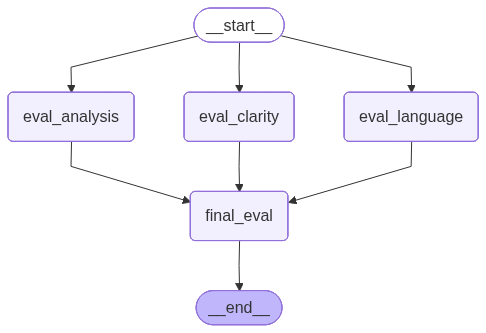

In [33]:
# Create a graph
graph = StateGraph(UPSCState)

# Create nodes
graph.add_node("eval_language", eval_language)
graph.add_node("eval_analysis", eval_analysis)
graph.add_node("eval_clarity", eval_clarity)
graph.add_node("final_eval", final_eval)

# Create edges
graph.add_edge(START, "eval_language")
graph.add_edge(START, "eval_analysis")
graph.add_edge(START, "eval_clarity")

graph.add_edge("eval_language", "final_eval")
graph.add_edge("eval_analysis", "final_eval")
graph.add_edge("eval_clarity", "final_eval")

graph.add_edge("final_eval", END)


# Compile the graph
workflow = graph.compile()
workflow

In [34]:
initial_state = {"essay":essay}
final_state = workflow.invoke(initial_state)
final_state

{'essay': 'The Role of Technology in Modern Education\n\nIn the twenty-first century, technology has become one of the most powerful tools shaping every aspect of human life. Among its many areas of influence, education has seen a dramatic transformation. From interactive classrooms to online learning platforms, technology has redefined how knowledge is delivered, accessed, and retained. While some critics argue that it reduces personal interaction and creates dependency, the benefits of technology in education outweigh its drawbacks by fostering accessibility, engagement, and lifelong learning.\n\nOne of the most significant contributions of technology to education is increased accessibility. In the past, students in remote or underdeveloped regions often lacked access to quality teachers and resources. Today, with the internet and digital devices, learners across the globe can access lectures from world-class universities, join virtual classrooms, and download educational materials. 